In [2]:
#load libraries 
import torch
from torchvision import transforms
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import Dataset,DataLoader
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import numpy as np
from pathlib import Path
from PIL import Image

In [3]:
# read the data
root_dir = "./datasets/Overlay_dataset//"

In [4]:
path = Path(root_dir)

In [5]:
path.is_dir()

True

In [6]:
# Get all image paths (of all the orignal images Only)
image_paths = list(path.glob("*/*.png"))
print(len(image_paths))

780


In [7]:
image_paths = list(path.glob("*/*.png"))


In [8]:
image_paths[0].parent.name

'benign'

In [9]:
# Extract labels froom folder names 
labels = [path.parent.name for path in image_paths]


In [10]:
print("Number of images from Benign",labels.count("benign") )
print("Number of images from normal",labels.count("normal") )
print("Number of images from malignant",labels.count("malignant"))



Number of images from Benign 437
Number of images from normal 133
Number of images from malignant 210


In [11]:
# Label encoding the labels 
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()

In [12]:
target_labels = label_encode.fit_transform(labels)

In [13]:
image_paths = np.array(image_paths)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    image_paths,
    target_labels,
    test_size=0.2,        # 20% test
    random_state=42,
    shuffle=True,
    stratify=target_labels  # VERY important for classification
)

In [15]:
# build custom dataset and dataloader 
class CustomDataset(Dataset): 
    def __init__(self,image_paths,labels): 
        self.images = image_paths
        self.labels = labels


    def __len__(self): 
        return len(self.images)


    def __getitem__(self,index):
        images = Image.open(self.images[index]).convert("RGB")
        
        # Convert to Tensor 
        images = transforms.ToTensor()(images)
        # Resize the image size
        resize_transform = transforms.Resize((224, 224))
        # Apply the transform
        resized_img = resize_transform(images)
        # labels 
        labels = torch.tensor(self.labels[index])
        return resized_img,labels

In [16]:
X_train_dataset = CustomDataset(X_train,y_train)
X_test_dataset = CustomDataset(X_test,y_test)

In [17]:
X_train_dataloader = DataLoader(X_train_dataset,batch_size=32,shuffle=True,drop_last=True)
X_test_dataloader = DataLoader(X_test_dataset,batch_size=32,shuffle=False,drop_last=True)

In [18]:
len(X_train_dataset)

624

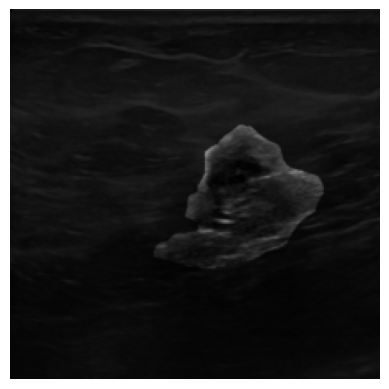

In [22]:

# Convert the tensor to channel-last format
image_np = X_train_dataset[90][0].permute(1, 2, 0).numpy()

# Display the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis labels
plt.show()

In [23]:
class MyModelEnhanced(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Block 4 (optional but powerful)
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Fix feature size
            nn.AdaptiveAvgPool2d((7, 7))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [32]:
# Configuration of My model 
learning_rate = 0.01
epochs = 75
loss_function = nn.CrossEntropyLoss()

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [34]:
device

device(type='cuda')

In [35]:
model = MyModelEnhanced(3)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)
torch.manual_seed(1123)
# training loop 
for epoch in range(epochs): 
    total_epoch_loss = 0
    for batch_images,batch_labels in X_train_dataloader: 
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        # pass forward 
        y_pred = model(batch_images)
        # loss calculate
        loss = loss_function(y_pred,batch_labels)
        
        # Clear the gradient 
        optimizer.zero_grad()
        # Backward propgationabs
        loss.backward()

        # Update weights 
        optimizer.step()
        total_epoch_loss += loss.item()

    print(f"Epoch {epoch + 1} : ",total_epoch_loss/len(X_train_dataloader))
        

Epoch 1 :  0.8274591847469932
Epoch 2 :  0.5876546408000746
Epoch 3 :  0.5214074395204845
Epoch 4 :  0.5148278678718367
Epoch 5 :  0.46926624680820267
Epoch 6 :  0.4489250292903499
Epoch 7 :  0.4413293647138696
Epoch 8 :  0.40538645104358073
Epoch 9 :  0.36251369902962133
Epoch 10 :  0.3052853839962106
Epoch 11 :  0.3443749084284431
Epoch 12 :  0.31673463630048854
Epoch 13 :  0.292031077177901
Epoch 14 :  0.2722524224143279
Epoch 15 :  0.2777996369098362
Epoch 16 :  0.2542287777913244
Epoch 17 :  0.2630878083015743
Epoch 18 :  0.21825339331438667
Epoch 19 :  0.21692709526733348
Epoch 20 :  0.2028445079922676
Epoch 21 :  0.1539764704280778
Epoch 22 :  0.1637277916858071
Epoch 23 :  0.18570771146761744
Epoch 24 :  0.16474793341599012
Epoch 25 :  0.1324823205604365
Epoch 26 :  0.10624113404437115
Epoch 27 :  0.1307532952020043
Epoch 28 :  0.10537982457562496
Epoch 29 :  0.11398927828198985
Epoch 30 :  0.05899213225041565
Epoch 31 :  0.090926321615514
Epoch 32 :  0.07186488454279147
Epoch 

In [36]:
# Evaluation of the model : Now the model will stop learning and modification into the exisiting learn parameters
model.eval()

MyModelEnhanced(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddi

In [69]:

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in X_test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()


In [70]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[49 25  0]
 [ 1 32  0]
 [ 0  1 20]]


In [71]:
from sklearn.metrics import classification_report

print(classification_report(
    all_labels,
    all_preds,
    target_names=["Benign", "Malignant", "Normal"]  # adjust order
))


              precision    recall  f1-score   support

      Benign       0.98      0.66      0.79        74
   Malignant       0.55      0.97      0.70        33
      Normal       1.00      0.95      0.98        21

    accuracy                           0.79       128
   macro avg       0.84      0.86      0.82       128
weighted avg       0.87      0.79      0.80       128



In [48]:
torch.save(model.state_dict(), "./models/model_rgb_epoch_with_overlly_simplified.pth")


In [ ]:
#model = MyModel(...)          # recreate architecture
#model.load_state_dict(torch.load("model.pth"))
#model.eval()


In [ ]:
'''
accu : 92

specification : epochs = 50 and lr = 0.02

accu : 94 
specification : epochs = 75 and lr = 0.01

'''

In [66]:
# Configuration of My model 
learning_rate = 0.02
epochs = 28
loss_function = nn.CrossEntropyLoss()

In [67]:
# Improve the training 
import torch
import matplotlib.pyplot as plt
model = MyModelEnhanced(3)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)
# Lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss, correct_train, total_train = 0, 0, 0

    for batch_images, batch_labels in X_train_dataloader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        y_pred = model(batch_images)
        loss = loss_function(y_pred, batch_labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * batch_images.size(0)
        _, predicted = torch.max(y_pred.data, 1)
        total_train += batch_labels.size(0)
        correct_train += (predicted == batch_labels).sum().item()

    avg_train_loss = total_train_loss / total_train
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    model.eval()
    total_test_loss, correct_test, total_test = 0, 0, 0

    with torch.no_grad():
        for test_images, test_labels in X_test_dataloader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            y_test_pred = model(test_images)
            loss_test = loss_function(y_test_pred, test_labels)

            total_test_loss += loss_test.item() * test_images.size(0)
            _, predicted_test = torch.max(y_test_pred.data, 1)
            total_test += test_labels.size(0)
            correct_test += (predicted_test == test_labels).sum().item()

    avg_test_loss = total_test_loss / total_test
    test_acc = correct_test / total_test
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}")


Epoch [1/28] | Train Loss: 0.7772, Train Acc: 0.6743 | Test Loss: 1.0205, Test Acc: 0.5781
Epoch [2/28] | Train Loss: 0.5392, Train Acc: 0.7303 | Test Loss: 1.1941, Test Acc: 0.5781
Epoch [3/28] | Train Loss: 0.5169, Train Acc: 0.7368 | Test Loss: 0.5385, Test Acc: 0.7266
Epoch [4/28] | Train Loss: 0.4871, Train Acc: 0.7599 | Test Loss: 0.4506, Test Acc: 0.8438
Epoch [5/28] | Train Loss: 0.4408, Train Acc: 0.7878 | Test Loss: 0.3916, Test Acc: 0.8125
Epoch [6/28] | Train Loss: 0.4291, Train Acc: 0.8010 | Test Loss: 0.5067, Test Acc: 0.7812
Epoch [7/28] | Train Loss: 0.3987, Train Acc: 0.8339 | Test Loss: 0.3303, Test Acc: 0.8750
Epoch [8/28] | Train Loss: 0.3245, Train Acc: 0.8701 | Test Loss: 0.3029, Test Acc: 0.8906
Epoch [9/28] | Train Loss: 0.3803, Train Acc: 0.8339 | Test Loss: 0.3101, Test Acc: 0.8984
Epoch [10/28] | Train Loss: 0.2891, Train Acc: 0.8849 | Test Loss: 0.2539, Test Acc: 0.9062
Epoch [11/28] | Train Loss: 0.2890, Train Acc: 0.8734 | Test Loss: 0.2823, Test Acc: 0.89

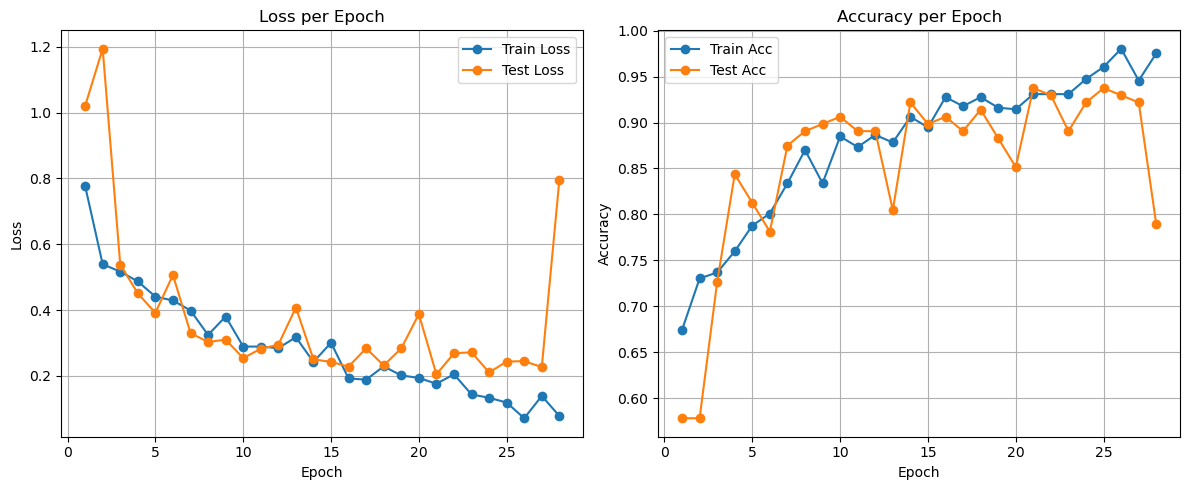

In [68]:
# Plot Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Acc', marker='o')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Acc', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def Objective(trails):
    
    